<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4 - Unveiling Chronic Disease in Singaporean Lifestyle

> Authors: Chung Yau, Gilbert, Han Kiong, Zheng Gang
---

**Problem Statement:**  
In Singapore, the increasing prevalence of chronic diseases presents a pressing public health concern, underscoring the need for proactive intervention strategies. 

How can we identify individuals at high risk for chronic diseases based on their behavioral habits? By doing so, we can enable early detection and provide recommendations, fostering a proactive approach to preventing various chronic diseases.

  
**Target Audience:**  
Product team in Synapxe, in preparation for Healthier SG 2025 roadmap workshop. 

These are the notebooks for this project:  
 1. `01_Data_Collection_Food.ipynb`  
 2. `02_Data_Preprocessing.ipynb`   
 3. `03_FeatureEngineering_and_EDA.ipynb`
 4. `04_Data_Modelling.ipynb` 
 5. `05_Hyperparameter_Model Fitting_Evaluation.ipynb`
 6. `05a_Model_Pickling.ipynb`
 7. `06_Implementation_FoodRecommender.ipynb` 

 ---

# This Notebook: 05_Hyperparameter_Model Fitting_Evaluation

Hyperparameter tuning is the process of finding the optimal combination of hyperparameter values that maximize the model's performance on a given task.

Different hyperparameter values can significantly impact the model's behavior, leading to underfitting (high bias, oversimplified model) or overfitting (high variance, model too complex for the data). Appropriate hyperparameter settings can help strike the right balance between bias and variance, resulting in better generalization performance on unseen data.

We also do an evaluation of our selected model in this notebook. 


---
### Import libraries and data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [2]:
# read cleaned csv file into a data frame
df = pd.read_csv('../data/03_asian_data.csv')

---
## Prepare data for pipeline model selection 
A pipeline is a way to chain multiple preprocessing steps and the final estimator into a sequence of steps. This allows the entire sequence to be treated as a single unit, making it easier to apply the same preprocessing steps consistently for both training and prediction.

#### Inspection of the dataframe

In [3]:
df.head()

,heart_attack,stroke,asthma,skin_cancer,other_cancer,cpd_bronchitis,depression,kidney_disease,diabetes,sex,martial,employment_status,blind,diff_walking,occasion_drink_30days,high_bp,heart_disease,arthritis,race,age,height,education,smoker_status,one_alc_per_day,binge_drink,ave_drink_week,fruit,vegetable,exercise_cat,high_cholesterol,weight,BMI,CD
0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,5,0,0,0,4,7.0,173.00000,2,0,1,0,2.330000e+02,0,0,2,1,6804.000000,22.733803,0
1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,4,3.0,157.00000,1,0,0,0,5.397605e-79,0,0,0,0,5897.000000,23.923891,0
2,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,4,10.0,173.00000,2,0,0,0,5.397605e-79,0,1,1,1,6350.000000,21.216880,0
3,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,1,4,8.0,169.36927,1,0,0,0,5.397605e-79,0,0,1,1,8048.087779,28.055853,1
4,0,0,0,0,0,0,0,0,0,1,1,0,0,0,5,0,0,0,4,9.0,180.00000,2,1,1,0,1.170000e+02,1,1,2,0,7484.000000,23.098765,0


In [4]:
# check rows and columns in df
df.shape

(16104, 33)

Dropping of '_RACE' column

In [5]:
# drop '_RACE' column
df.drop(columns=['race'], inplace=True)

In [6]:
# Checking percentage of occurrences of each unique value in the 'CD' column
print(df['CD'].value_counts())
print(df['CD'].value_counts(normalize = True)*100)

CD
0    10631
1     5473
Name: count, dtype: int64
CD
0    66.014655
1    33.985345
Name: proportion, dtype: float64


#### Create the training and testing data

In [7]:
# Train-test split
columns_to_check = [
    'cpd_bronchitis',  
    'depression',      
    'arthritis',       
    'heart_attack',    
    'stroke',          
    'asthma',          
    'diabetes',        
    'kidney_disease',  
    'heart_disease',   
    'CD',              
    'height',          
    'weight'           
]

X = df.drop(columns=columns_to_check)
y = df['CD']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

`stratify = y` replicates similar distribution of the classes pre-train/test split. This means that the train-test split algorithm will try to preserve the class proportions in both the training and test sets, ensuring that they are representative of the overall dataset.

In [8]:
# check columns in X
X.columns

Index(['skin_cancer', 'other_cancer', 'sex', 'martial', 'employment_status',
       'blind', 'diff_walking', 'occasion_drink_30days', 'high_bp', 'age',
       'education', 'smoker_status', 'one_alc_per_day', 'binge_drink',
       'ave_drink_week', 'fruit', 'vegetable', 'exercise_cat',
       'high_cholesterol', 'BMI'],
      dtype='object')

---
## Find the best fit

### Step 1a: Instantiate pipeline and `GridSearchCV`

`GridSearchCV` is a technique for automatically tuning the hyperparameters of a machine learning model. It defines a grid of hyperparameter values to explore, training the model with each combination of hyperparameters using cross-validation, and evaluating the model's performance using specified metrics (e.g., accuracy, sensitivity, F1-score).

Pipeline is chained together with the transformers or pre-processing steps (e.g. standardScaler, polynomialfeature, etc.) and the estimator or model (e.g. LogisticRegression, RandomForest, etc.).  

1. Define the Pipeline, by instantiating the `Pipeline()` class. Arguments to the class initiator are the "tasks" (e.g. vectorize, scaling, model) to be carried out in order. Pipeline is chained together with the Transformers and Estimator. 
2. Define the hyperparameters in a dictionary. Hyperparameters are the set of test parameters to be used by GridSearch. 
   - For each hyperparameter, go with the format `"<task_name>_ _ <parameter_name>" : [ <param1>, <param2>, <param3>,...]`
3. Instantiate a GridSearch for the Pipeline (defined in #1). 
   - First argument is the pipeline name
   - `param_grid` is the name of the hyperparameter dictionary defined in #2 
   - `scoring=f1` since we are trying to optimise sensitivity
   - `cv=10`

Note that we used cv = 10 as we see our models generally produce better train scores. This will help us overcome overfitting. 

In [9]:
# Perform RandomUnderSampler for class imbalance
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Define columns you want to apply polynomial features to
poly_cols = [
    'occasion_drink_30days',
    'BMI',             
    'education',   
    'smoker_status',   
    'exercise_cat',      
    'ave_drink_week',    
    'age'              
]
# Define PCA with n_components=30
pca = PCA(n_components=30)

# Create a ColumnTransformer to apply PolynomialFeatures to selected columns
poly_transformer = ColumnTransformer(
    transformers=[
        ('poly', PolynomialFeatures(), poly_cols)
    ],
    remainder='passthrough'  # Pass through columns not specified for polynomial features
)

# Pipeline #1:
# 1. Polynomialfeature, StandardScaler (using columntransformer)
# 2. Principal Component Analysis
# 3. Logistic Regression (estimator)
pipe_trans_lr = Pipeline([
    ('poly_transformer', poly_transformer),
    ('std_scaler', StandardScaler()),
    ('pca', pca),  # Apply PCA with n_components=30
    ('lr', LogisticRegression(random_state=42))
])

# define dictionary of hyperparameters spanning both transformers and estimators
pipe_trans_lr_param = {
    # 'poly_transformer__poly__degree': [2, 3],  # Polynomial degree
    # 'std_scaler__with_mean': [True, False],  # StandardScaler with_mean parameter
    # 'std_scaler__with_std': [True, False],  # StandardScaler with_std parameter
    'lr__solver': ['liblinear'], 
    'lr__C': np.logspace(-2, 1, num=10),
    'lr__penalty' : ['l2', 'l1'],
    'lr__class_weight': ['balanced',None],
    'lr__max_iter': [100,1000,3000]
}

# instantiate our GridSearchCV object
gs_trans_lr = GridSearchCV(pipe_trans_lr, 
                        param_grid=pipe_trans_lr_param,
                        scoring='f1', 
                        cv=10, verbose = 1)

# # Pipeline #2:
# 1. Polynomialfeature, StandardScaler (using columntransformer)
# 2. Principal Component Analysis
# 3. Support Vector Classifier (estimator)
pipe_trans_svc = Pipeline([
    ('poly_transformer', poly_transformer),
    ('std_scaler', StandardScaler()),
    ('pca', pca),  # Apply PCA with n_components=30
    ('svc', SVC(random_state=42))
])


# # define dictionary of hyperparameters spanning both transformers and estimators
pipe_trans_svc_param = {
    # 'poly_transformer__poly__degree': [2, 3],  # Polynomial degree
    # 'std_scaler__with_mean': [True, False],  # StandardScaler with_mean parameter
    # 'std_scaler__with_std': [True, False],  # StandardScaler with_std parameter
    # 'pca__n_components': [10],  # Number of components for PCA - pre-determined based on explained variances
    'svc__C': [0.01, 0.1, 1, 10],  # Regularization parameter
    # 'svc__kernel': ['linear', 'rbf', 'poly'],  # Kernel type
    # 'svc__gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    # 'svc__degree': [2, 3, 4],  # Degree of the polynomial kernel function
    'svc__class_weight': ['balanced']  # Weight of each class
}

# instantiate our GridSearchCV object
gs_trans_svc = GridSearchCV(pipe_trans_svc, 
                        param_grid=pipe_trans_svc_param, 
                        scoring='f1',
                        cv=10, verbose = 1)

### Step 1b: Add the newly configured `GridSearchCV` into the `grids` dictionary
- For each GridSearchCV object, assign an `id` (running number) which is the key in the dictionary.
- For each `id` key, the corresponding value is a dictionary.
    - `grid_search_obj` carries the object name of the GridSearchCV.
    - `grid_search_desc` is a description of the gridSearch, for user-friendly display in the report. 

In [10]:
grids = {

    1 : {
        "grid_search_obj": gs_trans_lr,
        "grid_search_desc" : "LogisticRegression",
    },

    2 : {
        "grid_search_obj": gs_trans_svc,
        "grid_search_desc" : "SupportVectorClassifier",
    },       
}


### Step 2: Execute the GridSearch
In the `grid_execute` list, specify which GridSearch `id` to be execute. 
- for all GridSearch `id` defined in the `grids` dictionary, the list of GridSearch will be executed. 
- if keyword "**ALL**" is provided, then all the `id` in the `grids` dictionary will be pulled, which mean all the defined GridSearch will be executed in one go. 


Note: `gs_result` is the dictionary that holds the grid search outcome for every execution.

In [11]:
### Specify the GridSearch `id` to be executed, in the `grid_execute` list 
#   ALWAYS IN A LIST, even if only single `id` is given.             
#   Keyword "ALL" will auto populate all the `id` from the `grids` dictionary into the lst                 
#################################
# grid_execute = [1, ] # only execute GridSearch for LogisticRegression
grid_execute = ["ALL",]
#################################

# initiate variable, do not tamper # 
best_score = 0.0
best_idx = 0
best_gs = ''
gs_result = {}
gs_execute = []

# pull out list of grid `id` for execution 
for ge in grid_execute:
	if len(grid_execute) == 1 and ge == "ALL":
		for i_, grid_cfg in grids.items():
			gs_execute.append(grid_cfg)
	else:
		gs_execute.append(grids[ge])

# GridSearch execution based on the defined list of `id`
for idx, ge in enumerate(gs_execute):
	gs = ge['grid_search_obj']
	gs_desc = ge['grid_search_desc']
	print('\n>>>>Estimator: %s', gs_desc)

	# Fit grid search	
	gs.fit(X_train_resampled, y_train_resampled)

	# Best params
	print('Best params: %s' % gs.best_params_)
	# Best training data accuracy
	print('Best training score: %.3f' % gs.best_score_)

	gs_result[gs_desc] = {}
	gs_result[gs_desc]['best_score'] = gs.best_score_
	gs_result[gs_desc]['best_param'] = gs.best_params_

	# Train scores
	train_y_pred = gs.predict(X_train)
	tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, train_y_pred).ravel()
	gs_result[gs_desc]['train_accuracy'] = (tp_train + tn_train) / (tp_train + tn_train + fp_train + fn_train)
	gs_result[gs_desc]['train_sensitivity'] = tp_train / (tp_train + fn_train)
	gs_result[gs_desc]['train_precision'] = tp_train / (tp_train + fp_train)
	gs_result[gs_desc]['train_f1_score'] = 2 * tp_train / (2 * tp_train + fp_train + fn_train)

	# Test scores
	test_y_pred = gs.predict(X_test)
	tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, test_y_pred).ravel()
	gs_result[gs_desc]['test_accuracy'] = (tp_test + tn_test) / (tp_test + tn_test + fp_test + fn_test)
	gs_result[gs_desc]['test_sensitivity'] = tp_test / (tp_test + fn_test)
	gs_result[gs_desc]['test_precision'] = tp_test / (tp_test + fp_test)
	gs_result[gs_desc]['test_f1_score'] = 2 * tp_test / (2 * tp_test + fp_test + fn_test)



>>>>Estimator: %s LogisticRegression
Fitting 10 folds for each of 120 candidates, totalling 1200 fits


Best params: {'lr__C': 0.021544346900318832, 'lr__class_weight': 'balanced', 'lr__max_iter': 100, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
Best training score: 0.672

>>>>Estimator: %s SupportVectorClassifier
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best params: {'svc__C': 0.01, 'svc__class_weight': 'balanced'}
Best training score: 0.681


### Step 3: Examine the results of GridSearch
- GridSearch results are captured in the `gs_result` dataframe for easier reading. 
- `gs_result` is exported into CSV for recording.

Once the GridSearch is fitted, we interpret the following information from the GridSearch object as follows :

| Property | Description |
| --- | ---|
| **`best_param`** | The hyperparameters that have been found to perform with the best score. |
| **`best_score`** | Best mean cross-validated score achieved. |
| **`accuracy (train and test)`** | Measures the overall correctness of the model's predictions, regardless of class. |
| **`f1_score (train and test)`** | Balanced measure of precision and recall, considering both false positives and false negatives. |
| **`precision (train and test)`** | Measures the proportion of correctly identified misinformation among all instances predicted as misinformation. |
| **`sensitivity (train and test)`** | Measures the proportion of actual misinformation that is correctly identified by the model. |



In [12]:
gs_result= pd.DataFrame(gs_result).T
gs_result

,best_score,best_param,train_accuracy,train_sensitivity,train_precision,train_f1_score,test_accuracy,test_sensitivity,test_precision,test_f1_score
LogisticRegression,0.671539,"{'lr__C': 0.021544346900318832, 'lr__class_wei...",0.718,0.625628,0.578703,0.601251,0.719652,0.637443,0.579734,0.607221
SupportVectorClassifier,0.680635,"{'svc__C': 0.01, 'svc__class_weight': 'balanced'}",0.683459,0.684788,0.526334,0.595196,0.681155,0.694977,0.523384,0.597097


---
### Step 4: Model Selection
Based on our problem statement, the task is to identify individuals at high risk for chronic diseases based on their lifestyle data. The significance of the evaluation metrics are as follows: 
- Accuracy: measures the proportion of correctly classified instances among all instances. In this context, accuracy indicates how well the model predicts both high-risk and not high-risk individuals. 
- Precision: measures the proportion of true high-risk individuals among all instances classified as high-risk. It focuses on minimizing false positives, i.e., instances wrongly classified as high-risk individuals. In this context, precision indicates the reliability of the model in correctly identifying high-risk individuals.
- Recall/ Sensitivity: measures the proportion of true high-risk individuals that are correctly identified by the classifier. It focuses on minimizing false negatives, i.e., high-risk individuals wrongly classified as not high-risk. In this context, recall indicates the ability of the model to capture all actual high-risk individuals.
- F1 Score: harmonic mean of precision and recall. It provides a balance between precision and recall, giving equal weight to both metrics. It summarizes the overall performance of the classifier, taking into account both precision and recall.

Comparison of the models' train and test scores

In general, a smaller difference between the train score and test score is preferred, as it suggests better generalization performance and less overfitting or underfitting. 

Accuracy: 

| Model                   | Train Score | Test Score | Difference  |
|-------------------------|-------------|------------|-------------|
| Logistic Regression     | 0.718       | 0.719652   | -0.001652   |
| Support Vector Classifier | 0.683381    | 0.681155   | 0.002226    |

Precision: 

| Model                   | Train Score | Test Score | Difference  |
|-------------------------|-------------|------------|-------------|
| Logistic Regression     | 0.578703    | 0.579734   | -0.001031   |
| Support Vector Classifier | 0.526242    | 0.523384   | 0.002858    |

Recall (Sensitivity):

| Model                   | Train Score | Test Score | Difference  |
|-------------------------|-------------|------------|-------------|
| Logistic Regression     | 0.625628    | 0.637443   | -0.011815   |
| Support Vector Classifier | 0.684788    | 0.694977   | -0.010189   |

F1 Scores:

| Model                   | Train Score | Test Score | Difference  |
|-------------------------|-------------|------------|-------------|
| Logistic Regression     | 0.601251    | 0.607221   | -0.005970   |
| Support Vector Classifier | 0.595136    | 0.597097   | -0.001961   |

**Evaluation:**  
Based on these tables, it is a regret that we do not see our model performance improving against our baseline for the test score. However, it is good that we see the difference between train and test score much better now. This means that the hypertuning allows our model to be able to generalize better compared to those at the baseline. 

The team has decided to go ahead with Logistic Regression as our model of choice since F1-score is the metric that we want to maximize and indeed Logistic Regression has the best F1 score. 

In addition, we see Logistic Regression also perform better for accuracy, precision compared to Support Vector Classifier. It is also a bonus that Logistic Regression runs faster against Support Vector Classifier.

---
## Model Evaluation

We will proceed to do a deeper evaluation of our selected model. The next step fits the Logistic Regression model with the parameters that we have found in the gridsearch. 

In [13]:

# Define the pipeline with best parameters
pipeline = Pipeline([
    ('poly_transformer', poly_transformer),
    ('std_scaler', StandardScaler()),
    ('pca', pca),  # Apply PCA with n_components=30
    ('lr', LogisticRegression(C=0.021544346900318832, class_weight='balanced',
                               max_iter=100, penalty='l1', solver='liblinear', random_state=42))
])

# Fit the pipeline to the training data
pipeline.fit(X_train_resampled, y_train_resampled)

# Predict on the train data
train_y_pred = pipeline.predict(X_train_resampled)

# Calculate evaluation metrics for train data
train_accuracy = accuracy_score(y_train_resampled, train_y_pred)
train_precision = precision_score(y_train_resampled, train_y_pred)
train_recall = recall_score(y_train_resampled, train_y_pred)
train_f1 = f1_score(y_train_resampled, train_y_pred)

# Predict on the test data
y_pred = pipeline.predict(X_test)

# Calculate evaluation metrics for test data
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

# Create DataFrames for  evaluation metrics
train_results_df = pd.DataFrame({
    'classifier': ['LogisticRegression'],
    'train accuracy': [train_accuracy],
    'train precision': [train_precision],
    'train recall': [train_recall],
    'train f1 score': [train_f1]
})

test_results_df = pd.DataFrame({
    'classifier': ['LogisticRegression'],
    'test accuracy': [test_accuracy],
    'test precision': [test_precision],
    'test recall': [test_recall],
    'test f1 score': [test_f1]
})

Validate train data to ensure aligns with above

In [14]:
train_results_df

,classifier,train accuracy,train precision,train recall,train f1 score
0,LogisticRegression,0.694724,0.725948,0.625628,0.672065


Validate test data to ensure aligns with above

In [15]:
test_results_df

,classifier,test accuracy,test precision,test recall,test f1 score
0,LogisticRegression,0.719652,0.579734,0.637443,0.607221


For this purpose of evaluation, we will utilize the follow tools:   

Confusion Matrix: A table that shows the accuracy of a classification model and allows for the assessment of which classes are often confused. It also helps calculate critical metrics like precision, recall, and F1 score.

ROC Curve: A plot that illustrates the trade-off between sensitivity (true positive rate) and specificity's complement (false positive rate) for different thresholds. It helps compare models or choose one based on specific performance needs, with the area under the curve (AUC) indicating the model's discriminative ability.

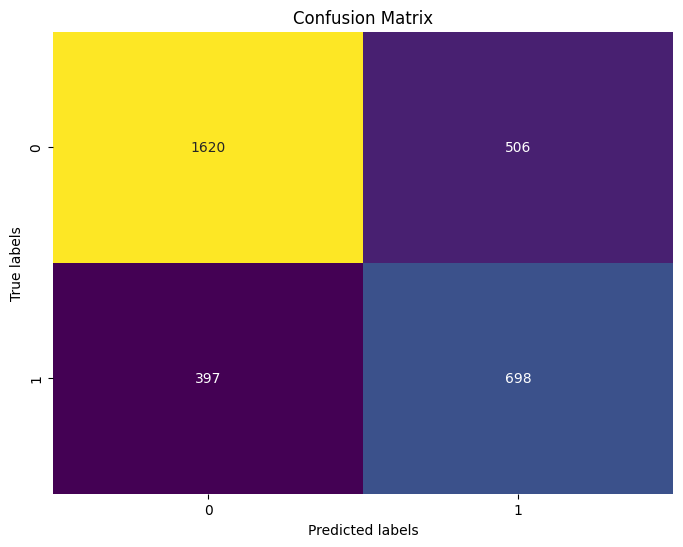

In [16]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

**Confusion Matrix**
- True Positives (TP): 1620
These are the instances where the model correctly predicted the positive class.
- True Negatives (TN): 698
These are the instances where the model correctly predicted the negative class.
- False Positives (FP): 506
These are the instances where the model incorrectly predicted the positive class when the actual class was negative.
- False Negatives (FN): 397
These are the instances where the model incorrectly predicted the negative class when the actual class was positive.
- Precision = TP / (TP + FP) = 1620 / (1620 + 506) = 0.762
Precision is the fraction of positive predictions that were correct.
- Recall (Sensitivity) = TP / (TP + FN) = 1620 / (1620 + 397) = 0.803
Recall is the fraction of actual positive instances that were correctly predicted.
- F1-score = 2 * (Precision * Recall) / (Precision + Recall) = 0.782
The F1-score is a harmonic mean of precision and recall, providing a balanced measure of performance.

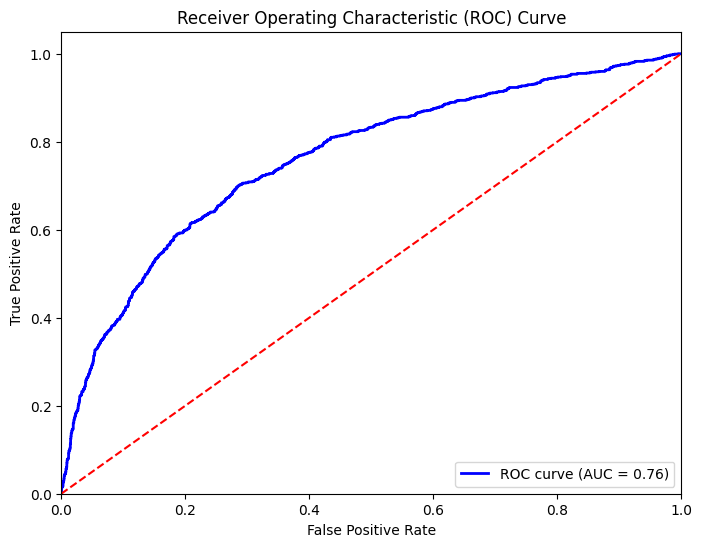

In [17]:
# Calculate probabilities
y_probs = pipeline.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculate AUC score
auc = roc_auc_score(y_test, y_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

**ROC Curve**
- The ROC curve plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various classification thresholds.
    - TPR is the same as Recall or Sensitivity, which is TP / (TP + FN).
    - FPR is the fraction of negative instances incorrectly classified as positive, which is FP / (FP + TN).
- The Area Under the Curve (AUC) is 0.76, as mentioned in the plot.
    - An AUC of 1.0 represents a perfect classifier, while an AUC of 0.5 is equivalent to random guessing.
    - An AUC of 0.76 indicates a moderately good classification performance, better than random guessing.
- The shape of the ROC curve suggests that the model has decent discriminative power, as the curve is reasonably far from the diagonal line (random guessing).
    - The curve rises steeply at low false positive rates, indicating that the model can achieve a high true positive rate with relatively few false positives.
    - As the false positive rate increases, the true positive rate continues to increase, but at a slower rate, indicating a trade-off between the two metrics.


Overall, the confusion matrix reveals a noticeable number of false positives and false negatives, while the ROC curve and AUC suggest moderately good classification performance. Further improvements may be possible by analyzing misclassified instances, adjusting the classification threshold, or exploring techniques to enhance the model's discriminative power. We will now look at some misclassification cases below. 

Cases where model wrongly predict user to have high risk of chronic disease but user does not. 

In [18]:

# Predict on the test data
y_pred = pipeline.predict(X_test)

# Create a boolean mask for predictions where y_pred is 0
mask_y_pred_zero = (y_pred == 0)

# Filter the rows in X_test where the predicted value is 0
zero_predictions_df = X_test[mask_y_pred_zero].copy()

# Add actual and predicted labels for clarity
zero_predictions_df['Actual'] = y_test[mask_y_pred_zero]
zero_predictions_df['Predicted'] = y_pred[mask_y_pred_zero]

# Display the DataFrame with predictions of 0
zero_predictions_df[zero_predictions_df["Actual"] == 1].describe().T

,count,mean,std,min,25%,50%,75%,max
skin_cancer,397.0,0.007557,0.086709,0.000000,0.000000,0.000000e+00,0.000000,1.000000
other_cancer,397.0,0.012594,0.111657,0.000000,0.000000,0.000000e+00,0.000000,1.000000
sex,397.0,0.433249,0.496150,0.000000,0.000000,0.000000e+00,1.000000,1.000000
martial,397.0,0.591940,0.492095,0.000000,0.000000,1.000000e+00,1.000000,1.000000
employment_status,397.0,0.687657,0.464033,0.000000,0.000000,1.000000e+00,1.000000,1.000000
blind,397.0,0.005038,0.070888,0.000000,0.000000,0.000000e+00,0.000000,1.000000
diff_walking,397.0,0.005038,0.070888,0.000000,0.000000,0.000000e+00,0.000000,1.000000
occasion_drink_30days,397.0,1.289673,2.409832,0.000000,0.000000,0.000000e+00,2.000000,15.000000
high_bp,397.0,0.083123,0.276417,0.000000,0.000000,0.000000e+00,0.000000,1.000000
age,397.0,4.314861,2.535427,1.000000,2.000000,4.000000e+00,6.000000,13.000000


Cases where model wrongly predict user to **NOT** have high risk of chronic disease but user does. 

In [19]:

# Predict on the test data
y_pred = pipeline.predict(X_test)

# Create a boolean mask for predictions where y_pred is 1
mask_y_pred_one = (y_pred == 1)

# Filter the rows in X_test where the predicted value is 1
one_predictions_df = X_test[mask_y_pred_one].copy()

# Add actual and predicted labels for clarity
one_predictions_df['Actual'] = y_test[mask_y_pred_one]
one_predictions_df['Predicted'] = y_pred[mask_y_pred_one]

# Display the DataFrame with predictions of 0
one_predictions_df[one_predictions_df["Actual"] == 0].describe().T

,count,mean,std,min,25%,50%,75%,max
skin_cancer,506.0,0.013834,0.116917,0.000000,0.000000,0.000000e+00,0.000000,1.000000
other_cancer,506.0,0.069170,0.253994,0.000000,0.000000,0.000000e+00,0.000000,1.000000
sex,506.0,0.415020,0.493213,0.000000,0.000000,0.000000e+00,1.000000,1.000000
martial,506.0,0.618577,0.486217,0.000000,0.000000,1.000000e+00,1.000000,1.000000
employment_status,506.0,0.488142,0.500354,0.000000,0.000000,0.000000e+00,1.000000,1.000000
blind,506.0,0.073123,0.260595,0.000000,0.000000,0.000000e+00,0.000000,1.000000
diff_walking,506.0,0.086957,0.282050,0.000000,0.000000,0.000000e+00,0.000000,1.000000
occasion_drink_30days,506.0,1.124506,2.355174,0.000000,0.000000,0.000000e+00,1.000000,15.000000
high_bp,506.0,0.533597,0.499364,0.000000,0.000000,1.000000e+00,1.000000,1.000000
age,506.0,8.691700,2.805195,1.000000,7.000000,9.000000e+00,11.000000,13.000000


Evaluation: Our model shows that the model have the tendency to wrong classify the users that are old age with high cholesterol and high blood pressure as high risk when they do not have chronic disease in fact. And vice versa. 
This aligns with our goal that we will also highlight these individuals as high risk despite them not having a doctor diagnosis. Cases like these impacts the test scores for our model and are in fact aligned with our use case. 

---
## Conclusion

In conclusion, in this notebook, we have attempted to hypertuned two models:
1. Logistic Regression
2. Support Vector Classification

Both of the hyperturned models do not show significant improvement from the baseline model. However, we see that the hypertuned models performed better in term of generalization as the gap between train and test scores are reduced. We chose Logistic Regression in the end due to the higher F1 and accuracy. 

We then did an analysis on items were classified wrongly by our model. They were mainly old age people with high blood pressure and high cholesterol, while they are not diagnosed with any chronic disease in our datasets, it makes empirical sense that these should be highlighted as high risk by our model. The next notebook will be with regards to the implementation of our recommendation model and this notebook will conclude the part on modelling. 

---
### Export hyperparameter tuning result
For offline reference and recording purpose

In [20]:
# Export data to csv
gs_result.to_csv('../data/05_hyperparameter_tuning_result.csv')